# Project Definition
### Problem Statement
Starbucks aims to optimize its promotional offer strategy by predicting whether customers will complete promotional offers (e.g., BOGO, discount, informational) based on their demographic profiles, transaction histories, and offer interactions. The current challenge lies in the imbalanced nature of the data, where many customers complete offers, but a significant minority do not, leading to potential biases in traditional predictive models. Inaccurate predictions can result in inefficient marketing campaigns, wasted resources, and missed opportunities to engage customers effectively. The goal is to develop a robust machine learning model that accurately identifies which customers are likely to complete offers, enabling Starbucks to target offers more precisely and improve campaign ROI.

### Project Overview
This project leverages customer data from Starbucks, including customer profiles (df_profile), transaction and offer event logs (df_trans_profile), and offer details (df_portfolio), to build and evaluate predictive models for offer completion. The data is cleaned, transformed, and merged into df_m and final_df, incorporating features such as age, income, event timestamps, transaction amounts, rewards, and encoded categorical variables like gender and offer type. Feature engineering and visualization are performed to uncover insights into customer behavior and offer engagement, followed by the development and tuning of three machine learning models—Logistic Regression, Random Forest, and XGBoost—using GridSearchCV for hyperparameter optimization. The models are evaluated on metrics like accuracy, precision, recall, and F1-score, with XGBoost identified as the best performer for deployment in a Flask application to enable real-time predictions. The project addresses class imbalance, ensures robust preprocessing (e.g., imputation, scaling), and aims to deliver actionable insights for Starbucks’ marketing strategy.

### Metric
To evaluate the performance of the predictive models and ensure alignment with Starbucks’ business objectives, the primary metric is the F1-Score, with secondary consideration of precision, recall, and accuracy. The F1-Score is chosen because it balances precision (the accuracy of positive predictions, critical for minimizing false positives in offer targeting) and recall (the ability to capture all actual offer completions, essential for maximizing campaign reach). Given the imbalanced nature of the data (more offer completions than non-completions), the F1-Score provides a more reliable measure of model performance across both classes compared to accuracy alone. Additionally, Precision-Recall AUC (PR-AUC) and ROC-AUC are used as supplementary metrics to assess model robustness on imbalanced datasets, ensuring the selected model (XGBoost) effectively supports Starbucks’ goal of optimizing offer completion predictions for real-time deployment.

#### Import Libraries
In this section, import all the necessary libraries for data manipulation, visualization, and modeling.

In [28]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

#### Load Data
Load the data from JSON files into Pandas DataFrames.

##### Description of Input Data
Datasets:

**portfolio.json:**

10 offers with attributes like offer_type (BOGO, discount), difficulty, reward, and channels (email, mobile).
Key Variable: id (unique offer ID).

**profile.json:**

17,000 customers with age, gender, income, and membership start date (became_member_on).
Key Issue: age=118 (invalid) and missing income values.

**transcript.json:**

306,534 events (offer received/viewed/completed, transactions).
Nested Data: value column contains offer_id, amount, or reward.

In [29]:
# Load the data
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

##### Display the first few rows of each dataframe

In [30]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [31]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [32]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


## Initial Exploration
Perform initial exploration of the data to understand its structure and check for missing values.

In [33]:
# Perform initial exploration
print(portfolio.info())
print(profile.info())
print(transcript.info())

# Check for missing values
print(portfolio.isnull().sum())
print(profile.isnull().sum())
print(transcript.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 612.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB
None
<class 'panda

## Data Cleaning
In this section, we clean the data by filling missing values and encoding categorical variables.

In [34]:
# Data Transformation
df_fixd = transcript.copy()

def safe_eval(val):
    if isinstance(val, str):
        return ast.literal_eval(val)
    return val

df_fixd['value'] = df_fixd['value'].apply(safe_eval)
df_fixd['offer_id'] = df_fixd['value'].apply(lambda x: x.get('offer id', None))
df_fixd['amount'] = df_fixd['value'].apply(lambda x: x.get('amount', None))
df_fixd['reward'] = df_fixd['value'].apply(lambda x: x.get('reward', None))
df_fixd.drop(columns=['value'], inplace=True)
df_fixd

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,None,1.59,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,None,9.53,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,None,3.61,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,None,3.53,NaN


In [35]:
# Data Cleaning
df_profile = profile.copy()
df_profile['age'].replace(118, np.nan)
df_profile['age'].fillna(df_profile['age'].mean().round(0))
df_profile['age'] = df_profile['age'].astype(int)
df_profile['became_member_on'] = pd.to_datetime(
    df_profile['became_member_on'], format='%Y%m%d', errors='coerce')
df_profile['income'] = df_profile['income'].fillna(
    df_profile['income'].mean().round(0)).astype(int)
df_profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65405
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,65405
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,65405
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000


In [36]:
df_trans_profile = pd.merge(
    df_fixd, df_profile, left_on='person', right_on='id', how='left')
df_trans_profile.drop(columns=['id'], inplace=True)
df_trans_profile['offer_id'] = df_trans_profile['offer_id'].fillna('N/A')
df_trans_profile['gender'] = df_trans_profile['gender'].fillna('N/A')
df_trans_profile

,person,event,time,offer_id,amount,reward,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,F,75,2017-05-09,100000
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,N/A,118,2017-08-04,65405
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,M,68,2018-04-26,70000
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,N/A,118,2017-09-25,65405
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,N/A,118,2017-10-02,65405
...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,N/A,1.59,NaN,M,66,2018-01-01,47000
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,N/A,9.53,NaN,M,52,2018-04-08,62000
306531,a00058cf10334a308c68e7631c529907,transaction,714,N/A,3.61,NaN,F,63,2013-09-22,52000
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,N/A,3.53,NaN,M,57,2016-07-09,40000


In [37]:
df_trans_profile['event'].value_counts()

event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

In [38]:
df_trans_profile['offer_id'].value_counts()

offer_id
N/A                                 172532
2298d6c36e964ae4a3e7e9706d1fb8c2     14983
fafdcd668e3743c1bb461111dcafc2a4     14924
4d5c57ea9a6940dd891ad53e9dbe8da0     14891
f19421c1d4aa40978ebb69ca19b0e20d     14835
ae264e3637204a6fb9bb56bc8210ddfd     14374
5a8bc65990b245e5a138643cd4eb9837     14305
9b98b8c7a33c4b65b9aebfe6a799e6d9     11848
3f207df678b143eea3cee63160fa8bed     11761
2906b810c7d4411798c6938adc9daaa5     11750
0b1e1539f2cc45b7b9fa7c272da2e1d7     10331
Name: count, dtype: int64

In [39]:
duplicate_counts = df_trans_profile['person'].duplicated().sum()
print(f"Number of duplicate persons: {duplicate_counts}")

Number of duplicate persons: 289534


In [40]:
person_counts = df_trans_profile['person'].value_counts()
person_counts

person
94de646f7b6041228ca7dec82adb97d2    51
8dbfa485249f409aa223a2130f40634a    49
d0a80415b84c4df4908b8403b19765e3    48
5e60c6aa3b834e44b822ea43a3efea26    48
79d9d4f86aca4bed9290350fb43817c2    48
                                    ..
afd41b230f924f9ca8f5ed6249616114     2
3a4e53046c544134bb1e7782248631d1     2
e63e42480aae4ede9f07cac49c8c3f78     2
7ecfc592171f4844bdc05bdbb48d3847     2
da7a7c0dcfcb41a8acc7864a53cf60fb     1
Name: count, Length: 17000, dtype: int64

## Data Visualization
In this section, we visualize the data to gain insights into the distributions and relationships between variables.

In [41]:
import plotly.express as px

# Gender Distribution
fig = px.histogram(profile, x='gender', title='Gender Distribution')
fig.show()

# Income Distribution
fig = px.histogram(profile, x='income', nbins=20, title='Income Distribution')
fig.show()

# Age Distribution
fig = px.histogram(profile, x='age', nbins=20, title='Age Distribution')
fig.show()

# Scatter plot of Age vs Income
fig = px.scatter(profile, x='age', y='income', color='gender', title='Age vs Income')
fig.show()

# Box plot of Income by Gender
fig = px.box(profile, x='gender', y='income', title='Income by Gender')
fig.show()

## Feature Engineering
create new features from the existing data to improve the performance of our models.

## Methodology
### Refinement
***The refinement process focused on enhancing the quality and relevance of the dataset and models to improve predictive accuracy for customer offer completion. Initially, the raw data from df_profile, df_trans_profile, and df_portfolio were analyzed for missing values, duplicates, and inconsistencies. Key refinements included:***

 * Replacing placeholder values (e.g., age = 118) with the mean age and filling missing income values with the mean income to ensure numerical completeness.
 * Standardizing categorical variables, such as replacing missing gender values with 'Unknown' or 'N/A' and encoding them as dummy variables (e.g., gender_F, gender_M, gender_O, gender_Unknown).
 * Addressing class imbalance in the target variable (event_offer completed) by exploring techniques like class weights and oversampling (e.g., SMOTE) to improve model performance on the minority class (offers not completed).
 * Iteratively tuning model hyperparameters using GridSearchCV, adjusting the parameter grids for Logistic Regression, Random Forest, and XGBoost to optimize performance metrics like F1-score, precision, and recall, rather than relying solely on accuracy due to the imbalanced dataset.
 * Refining features by analyzing feature importance from Random Forest, XGBoost, and Logistic Regression coefficients, removing or transforming features with low importance or high redundancy to enhance model interpretability and performance.
### Implementation
The implementation phase involved building, training, and evaluating the machine learning models to predict offer completion, followed by preparing the best model for deployment. The process included:

 * **Data Preparation:** Merging df_trans_profile and df_profile into df_m and final_df, incorporating offer details from df_portfolio. Features such as age, income, event timestamps, transaction amounts, rewards, and encoded categorical variables (e.g., offer type, gender, channels) were extracted and engineered.
 * **Model Development:** Three models were implemented using scikit-learn and XGBoost pipelines:
 * **Logistic Regression:** Used a pipeline with SimpleImputer, StandardScaler, and LogisticRegression, tuned with GridSearchCV on parameters like C, penalty, and solver.
 * **Random Forest:** Used a pipeline with SimpleImputer and RandomForestClassifier, tuned on n_estimators, max_depth, and min_samples_split.
 * **XGBoost:** Used a pipeline with SimpleImputer and XGBClassifier, tuned on n_estimators, max_depth, and learning_rate.
 * **Training and Evaluation:** Each model was trained on 70% of the data (X_train, y_train) and evaluated on 30% (X_test, y_test) using 3-fold cross-validation. Metrics (accuracy, precision, recall, F1-score) were calculated, and XGBoost was selected as the best model based on its balanced performance (highest precision and competitive F1-score) and robustness for real-time predictions.
 * **Deployment Preparation:** The best model was saved using joblib for integration into a Flask application, enabling real-time predictions of offer completion based on customer features.
### Data Processing
The data processing phase involved cleaning, transforming, and engineering the raw datasets to create a modeling-ready dataset. The steps included:

 * **Data Loading:** Loading df_profile, df_trans_profile, and df_portfolio from JSON files into pandas DataFrames, ensuring proper orientation and structure.
 * **Initial Exploration:** Checking data structure, missing values, and duplicates (e.g., duplicate_counts in df_trans_profile) to understand the dataset’s quality and identify preprocessing needs.
### Cleaning:
Handling missing values in df_profile by filling age and income NaNs with their means and replacing gender NaNs with 'Unknown' or 'N/A'.
Transforming nested data in df_trans_profile (e.g., extracting 'offer_id', 'amount', 'reward' from the 'value' column) using ast.literal_eval and lambda functions.
Standardizing datetime fields (e.g., became_member_on) to pandas datetime format.
### Transformation and Merging:
Creating df_trans_profile by merging df_fixd (transformed transcript) with df_profile on 'person' and 'id', then dropping redundant columns.
Generating final_df by merging df_grouped with df_portfolio on 'offer_id_offer_received' and 'id', adding offer details like reward, channels, difficulty, duration, and offer type.
### Feature Engineering:
Encoding categorical variables (e.g., offer_type, gender, event) into dummy variables using pd.get_dummies.
Parsing and encoding channels into binary columns (channel_email, channel_mobile, channel_social, channel_web).
Aggregating event-specific data (e.g., time_offer_received, amount_transaction) at the person level in df_grouped, using aggregations like 'first' and 'max'.
 * **Final Dataset (df_m):** Producing a cleaned, encoded dataset with 31 columns, including numeric features (e.g., age, income), binary event indicators, time metrics, and one-hot encoded categorical variables, ready for modeling.

In [42]:
# Feature Engineering
df = df_trans_profile.copy()
event_dummies = pd.get_dummies(df['event'], prefix='event')
df = pd.concat([df, event_dummies], axis=1)
time_columns = {
    'offer received': 'time_offer_received',
    'offer viewed': 'time_offer_viewed',
    'transaction': 'time_transaction',
    'offer completed': 'time_offer_completed'
}
amount_columns = {
    'offer received': 'amount_offer_received',
    'offer viewed': 'amount_offer_viewed',
    'transaction': 'amount_transaction',
    'offer completed': 'amount_offer_completed'
}
reward_columns = {
    'offer received': 'reward_offer_received',
    'offer viewed': 'reward_offer_viewed',
    'transaction': 'reward_transaction',
    'offer completed': 'reward_offer_completed'
}
offer_id_columns = {
    'offer received': 'offer_id_offer_received',
    'offer viewed': 'offer_id_offer_viewed',
    'transaction': 'offer_id_transaction',
    'offer completed': 'offer_id_offer_completed'
}
for event, time_col in time_columns.items():
    df[time_col] = df.apply(lambda row: row['time']
                            if row['event'] == event else None, axis=1)
    df[amount_columns[event]] = df.apply(
        lambda row: row['amount'] if row['event'] == event else None, axis=1)
    df[reward_columns[event]] = df.apply(
        lambda row: row['reward'] if row['event'] == event else None, axis=1)
    df[offer_id_columns[event]] = df.apply(
        lambda row: row['offer_id'] if row['event'] == event else None, axis=1)
df.drop(columns=['event', 'time', 'amount',
        'reward', 'offer_id'], inplace=True)
df_grouped = df.groupby('person').agg({
    'gender': 'first',
    'age': 'first',
    'became_member_on': 'first',
    'income': 'first',
    'event_offer received': 'max',
    'event_offer viewed': 'max',
    'event_transaction': 'max',
    'event_offer completed': 'max',
    'time_offer_received': 'first',
    'time_offer_viewed': 'first',
    'time_transaction': 'first',
    'time_offer_completed': 'first',
    'amount_offer_received': 'first',
    'amount_offer_viewed': 'first',
    'amount_transaction': 'first',
    'amount_offer_completed': 'first',
    'reward_offer_received': 'first',
    'reward_offer_viewed': 'first',
    'reward_transaction': 'first',
    'reward_offer_completed': 'first',
    'offer_id_offer_received': 'first',
    'offer_id_offer_viewed': 'first',
    'offer_id_transaction': 'first',
    'offer_id_offer_completed': 'first'
}).reset_index()
df_grouped

,person,gender,age,became_member_on,income,event_offer received,event_offer viewed,event_transaction,event_offer completed,time_offer_received,...,amount_transaction,amount_offer_completed,reward_offer_received,reward_offer_viewed,reward_transaction,reward_offer_completed,offer_id_offer_received,offer_id_offer_viewed,offer_id_transaction,offer_id_offer_completed
0,0009655768c64bdeb2e877511632db8f,M,33,2017-04-21,72000,True,True,True,True,168.0,...,22.16,NaN,NaN,NaN,NaN,5.0,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,N/A,N/A
1,00116118485d4dfda04fdbaba9a87b5c,N/A,118,2018-04-25,65405,True,True,True,False,168.0,...,0.70,NaN,NaN,NaN,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d,N/A,None
2,0011e0d4e6b944f998e987f904e8c1e5,O,40,2018-01-09,57000,True,True,True,True,0.0,...,13.49,NaN,NaN,NaN,NaN,3.0,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,N/A,N/A
3,0020c2b971eb4e9188eac86d93036a77,F,59,2016-03-04,90000,True,True,True,True,0.0,...,17.63,NaN,NaN,NaN,NaN,2.0,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4,N/A,N/A
4,0020ccbbb6d84e358d3414a3ff76cffd,F,24,2016-11-11,60000,True,True,True,True,168.0,...,16.27,NaN,NaN,NaN,NaN,3.0,2298d6c36e964ae4a3e7e9706d1fb8c2,2298d6c36e964ae4a3e7e9706d1fb8c2,N/A,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,fff3ba4757bd42088c044ca26d73817a,F,69,2015-09-20,83000,True,True,True,True,0.0,...,20.98,NaN,NaN,NaN,NaN,2.0,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4,N/A,N/A
16996,fff7576017104bcc8677a8d63322b5e1,M,71,2017-10-31,73000,True,True,True,True,0.0,...,5.55,NaN,NaN,NaN,NaN,2.0,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4,N/A,N/A
16997,fff8957ea8b240a6b5e634b6ee8eafcf,M,71,2018-02-18,56000,True,True,True,False,408.0,...,0.64,NaN,NaN,NaN,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4,N/A,None
16998,fffad4f4828548d1b5583907f2e9906b,M,34,2017-01-23,34000,True,True,True,True,0.0,...,6.97,NaN,NaN,NaN,NaN,5.0,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d,N/A,N/A


In [43]:
df_grouped.dropna(axis=1, how='all', inplace=True)
df_grouped

,person,gender,age,became_member_on,income,event_offer received,event_offer viewed,event_transaction,event_offer completed,time_offer_received,time_offer_viewed,time_transaction,time_offer_completed,amount_transaction,reward_offer_completed,offer_id_offer_received,offer_id_offer_viewed,offer_id_transaction,offer_id_offer_completed
0,0009655768c64bdeb2e877511632db8f,M,33,2017-04-21,72000,True,True,True,True,168.0,192.0,228.0,414.0,22.16,5.0,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,N/A,N/A
1,00116118485d4dfda04fdbaba9a87b5c,N/A,118,2018-04-25,65405,True,True,True,False,168.0,216.0,294.0,NaN,0.70,NaN,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d,N/A,None
2,0011e0d4e6b944f998e987f904e8c1e5,O,40,2018-01-09,57000,True,True,True,True,0.0,6.0,132.0,252.0,13.49,3.0,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,N/A,N/A
3,0020c2b971eb4e9188eac86d93036a77,F,59,2016-03-04,90000,True,True,True,True,0.0,12.0,54.0,54.0,17.63,2.0,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4,N/A,N/A
4,0020ccbbb6d84e358d3414a3ff76cffd,F,24,2016-11-11,60000,True,True,True,True,168.0,168.0,42.0,222.0,16.27,3.0,2298d6c36e964ae4a3e7e9706d1fb8c2,2298d6c36e964ae4a3e7e9706d1fb8c2,N/A,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,fff3ba4757bd42088c044ca26d73817a,F,69,2015-09-20,83000,True,True,True,True,0.0,6.0,6.0,6.0,20.98,2.0,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4,N/A,N/A
16996,fff7576017104bcc8677a8d63322b5e1,M,71,2017-10-31,73000,True,True,True,True,0.0,24.0,36.0,192.0,5.55,2.0,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4,N/A,N/A
16997,fff8957ea8b240a6b5e634b6ee8eafcf,M,71,2018-02-18,56000,True,True,True,False,408.0,432.0,18.0,NaN,0.64,NaN,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4,N/A,None
16998,fffad4f4828548d1b5583907f2e9906b,M,34,2017-01-23,34000,True,True,True,True,0.0,6.0,36.0,36.0,6.97,5.0,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d,N/A,N/A


In [44]:
# Data Transformation
final_df = pd.merge(df_grouped, portfolio,
                    left_on='offer_id_offer_received', right_on='id', how='left')
final_df.drop(columns=['id'], inplace=True)
final_df

,person,gender,age,became_member_on,income,event_offer received,event_offer viewed,event_transaction,event_offer completed,time_offer_received,...,reward_offer_completed,offer_id_offer_received,offer_id_offer_viewed,offer_id_transaction,offer_id_offer_completed,reward,channels,difficulty,duration,offer_type
0,0009655768c64bdeb2e877511632db8f,M,33,2017-04-21,72000,True,True,True,True,168.0,...,5.0,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,N/A,N/A,0.0,"[email, mobile, social]",0.0,3.0,informational
1,00116118485d4dfda04fdbaba9a87b5c,N/A,118,2018-04-25,65405,True,True,True,False,168.0,...,NaN,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d,N/A,None,5.0,"[web, email, mobile, social]",5.0,5.0,bogo
2,0011e0d4e6b944f998e987f904e8c1e5,O,40,2018-01-09,57000,True,True,True,True,0.0,...,3.0,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,N/A,N/A,0.0,"[web, email, mobile]",0.0,4.0,informational
3,0020c2b971eb4e9188eac86d93036a77,F,59,2016-03-04,90000,True,True,True,True,0.0,...,2.0,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4,N/A,N/A,2.0,"[web, email, mobile, social]",10.0,10.0,discount
4,0020ccbbb6d84e358d3414a3ff76cffd,F,24,2016-11-11,60000,True,True,True,True,168.0,...,3.0,2298d6c36e964ae4a3e7e9706d1fb8c2,2298d6c36e964ae4a3e7e9706d1fb8c2,N/A,N/A,3.0,"[web, email, mobile, social]",7.0,7.0,discount
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,fff3ba4757bd42088c044ca26d73817a,F,69,2015-09-20,83000,True,True,True,True,0.0,...,2.0,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4,N/A,N/A,2.0,"[web, email, mobile, social]",10.0,10.0,discount
16996,fff7576017104bcc8677a8d63322b5e1,M,71,2017-10-31,73000,True,True,True,True,0.0,...,2.0,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4,N/A,N/A,2.0,"[web, email, mobile, social]",10.0,10.0,discount
16997,fff8957ea8b240a6b5e634b6ee8eafcf,M,71,2018-02-18,56000,True,True,True,False,408.0,...,NaN,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4,N/A,None,2.0,"[web, email, mobile, social]",10.0,10.0,discount
16998,fffad4f4828548d1b5583907f2e9906b,M,34,2017-01-23,34000,True,True,True,True,0.0,...,5.0,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d,N/A,N/A,5.0,"[web, email, mobile, social]",5.0,5.0,bogo


In [45]:
final_df.columns

Index(['person', 'gender', 'age', 'became_member_on', 'income',
       'event_offer received', 'event_offer viewed', 'event_transaction',
       'event_offer completed', 'time_offer_received', 'time_offer_viewed',
       'time_transaction', 'time_offer_completed', 'amount_transaction',
       'reward_offer_completed', 'offer_id_offer_received',
       'offer_id_offer_viewed', 'offer_id_transaction',
       'offer_id_offer_completed', 'reward', 'channels', 'difficulty',
       'duration', 'offer_type'],
      dtype='object')

In [46]:
data = final_df.copy()
data.dropna(subset=['gender', 'age', 'income',
            'became_member_on'], inplace=True)
data['became_member_on'] = pd.to_datetime(data['became_member_on'])
data['event_offer received'] = data['event_offer received'].astype(bool)
data['event_offer viewed'] = data['event_offer viewed'].astype(bool)
data['event_transaction'] = data['event_transaction'].astype(bool)
data['event_offer completed'] = data['event_offer completed'].astype(bool)
data['will_complete_offer'] = data['event_offer completed'].astype(int)
data.drop(columns=['person', 'channels', 'offer_id_offer_received',
          'offer_id_offer_viewed', 'reward', 'reward_offer_completed'], inplace=True)
data.head()

,gender,age,became_member_on,income,event_offer received,event_offer viewed,event_transaction,event_offer completed,time_offer_received,time_offer_viewed,time_transaction,time_offer_completed,amount_transaction,offer_id_transaction,offer_id_offer_completed,difficulty,duration,offer_type,will_complete_offer
0,M,33,2017-04-21,72000,True,True,True,True,168.0,192.0,228.0,414.0,22.16,N/A,N/A,0.0,3.0,informational,1
1,N/A,118,2018-04-25,65405,True,True,True,False,168.0,216.0,294.0,NaN,0.70,N/A,None,5.0,5.0,bogo,0
2,O,40,2018-01-09,57000,True,True,True,True,0.0,6.0,132.0,252.0,13.49,N/A,N/A,0.0,4.0,informational,1
3,F,59,2016-03-04,90000,True,True,True,True,0.0,12.0,54.0,54.0,17.63,N/A,N/A,10.0,10.0,discount,1
4,F,24,2016-11-11,60000,True,True,True,True,168.0,168.0,42.0,222.0,16.27,N/A,N/A,7.0,7.0,discount,1


In [47]:
import pandas as pd
import numpy as np
import ast

# Create a copy of the dataframe
df_m = final_df.copy()

# Handle age column
df_m['age'] = pd.to_numeric(df_m['age'], errors='coerce')
df_m['age'] = df_m['age'].replace(118, np.nan)
df_m['age'] = df_m['age'].fillna(df_m['age'].mean()).astype(int)

# Handle income column
df_m['income'] = pd.to_numeric(df_m['income'], errors='coerce')
df_m['income'] = df_m['income'].fillna(df_m['income'].mean()).astype(int)

# Handle channels column


def parse_channels(x):
    """Safely parse channel strings into lists."""
    # Handle scalar NaN or None
    if isinstance(x, (float, type(None))) and pd.isna(x):
        return []
    # Handle already-parsed lists
    if isinstance(x, list):
        return x
    # Handle numpy arrays
    if isinstance(x, np.ndarray):
        return x.tolist()
    # Handle string representations
    if isinstance(x, str):
        try:
            parsed = ast.literal_eval(x)
            return parsed if isinstance(parsed, list) else []
        except (ValueError, SyntaxError):
            return []
    return []  # Default case for any other type


# Apply channel parsing and create binary columns
df_m['channels'] = df_m['channels'].apply(parse_channels)
channel_types = ['email', 'mobile', 'social', 'web']
for channel in channel_types:
    df_m[f'channel_{channel}'] = df_m['channels'].apply(
        lambda x: 1 if isinstance(
            x, (list, np.ndarray)) and channel in x else 0
    )

# Drop unnecessary columns with error handling
columns_to_drop = ['channels', 'offer_id_offer_viewed', 'person']
df_m = df_m.drop(
    columns=[col for col in columns_to_drop if col in df_m.columns])

# One-hot encode categorical columns with proper handling of missing values
categorical_cols = ['offer_type', 'gender']
for col in categorical_cols:
    if col in df_m.columns:
        df_m[col] = df_m[col].fillna('Unknown')
        df_m = pd.get_dummies(df_m, columns=[col], prefix=col, dummy_na=False)

# Display the resulting dataframe
df_m

,age,became_member_on,income,event_offer received,event_offer viewed,event_transaction,event_offer completed,time_offer_received,time_offer_viewed,time_transaction,...,channel_social,channel_web,offer_type_Unknown,offer_type_bogo,offer_type_discount,offer_type_informational,gender_F,gender_M,gender_N/A,gender_O
0,33,2017-04-21,72000,True,True,True,True,168.0,192.0,228.0,...,1,0,False,False,False,True,False,True,False,False
1,54,2018-04-25,65405,True,True,True,False,168.0,216.0,294.0,...,1,1,False,True,False,False,False,False,True,False
2,40,2018-01-09,57000,True,True,True,True,0.0,6.0,132.0,...,0,1,False,False,False,True,False,False,False,True
3,59,2016-03-04,90000,True,True,True,True,0.0,12.0,54.0,...,1,1,False,False,True,False,True,False,False,False
4,24,2016-11-11,60000,True,True,True,True,168.0,168.0,42.0,...,1,1,False,False,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,69,2015-09-20,83000,True,True,True,True,0.0,6.0,6.0,...,1,1,False,False,True,False,True,False,False,False
16996,71,2017-10-31,73000,True,True,True,True,0.0,24.0,36.0,...,1,1,False,False,True,False,False,True,False,False
16997,71,2018-02-18,56000,True,True,True,False,408.0,432.0,18.0,...,1,1,False,False,True,False,False,True,False,False
16998,34,2017-01-23,34000,True,True,True,True,0.0,6.0,36.0,...,1,1,False,True,False,False,False,True,False,False


#### Second EDA after feature engineering

In [48]:
# Data Visualization
fig1 = px.histogram(data, x='age', nbins=30,
                    marginal='rug', title='Age Distribution')
fig1.update_layout(bargap=0.2)
fig1.show()
fig2 = px.histogram(data, x='gender', title='Gender Distribution')
fig2.update_layout(bargap=0.2)
fig2.show()
fig3 = px.histogram(data, x='income', nbins=30,
                    marginal='rug', title='Income Distribution')
fig3.update_layout(bargap=0.2)
fig3.show()
fig4 = px.histogram(data, x='gender', color='will_complete_offer',
                    title='Offer Completion by Gender', barmode='group')
fig4.update_layout(bargap=0.2)
fig4.show()
data['age_group'] = pd.cut(
    data['age'], bins=[18, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120])
data['age_group_mid'] = data['age_group'].apply(
    lambda x: x.mid if pd.notna(x) else None)
fig5 = px.histogram(data, x='age_group_mid', color='will_complete_offer',
                    title='Offer Completion by Age Group', barmode='group')
fig5.update_layout(bargap=0.2, xaxis={'tickangle': 45})
fig5.show()
data['income_group'] = pd.cut(
    data['income'], bins=[0, 30000, 60000, 90000, 120000, 150000])
data['income_group_mid'] = data['income_group'].apply(
    lambda x: x.mid if pd.notna(x) else None)
fig6 = px.histogram(data, x='income_group_mid', color='will_complete_offer',
                    title='Offer Completion by Income Group', barmode='group')
fig6.update_layout(bargap=0.2, xaxis={'tickangle': 45})
fig6.show()

# Results

### Model Building
In this section, I build and evaluate a machine learning model to predict a target variable.

In [49]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer

In [50]:
df=df_m.copy()
features = [
'age', 'income', 'event_offer received', 'event_offer viewed', 'event_transaction',
'time_offer_received', 'time_offer_viewed', 'time_transaction', 'amount_transaction',
'reward', 'difficulty', 'channel_email', 'channel_mobile', 'channel_social', 'channel_web',
'offer_type_bogo', 'offer_type_discount', 'offer_type_informational', 'gender_F', 'gender_M', 'gender_O'
]
X = df[features]
y = df['event_offer completed']

In [51]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [52]:
"""Train Logistic Regression with GridSearchCV"""
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Added to handle NaN
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=300, random_state=42))
])

param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear']  # Compatible with l1 and l2
}

In [53]:
"""Train Random Forest with GridSearchCV"""
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Added to handle NaN
    ('clf', RandomForestClassifier(random_state=42))
])

param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5]
}


In [54]:
"""Train XGBoost with GridSearchCV"""
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Added to handle NaN
    ('clf', XGBClassifier(random_state=42, eval_metric='logloss'))
])

param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 5],
    'clf__learning_rate': [0.01, 0.1]
}



## Model Evaluation
In this section, we evaluate the performance of machine learning model using various metrics and visualizations.

In [55]:
"""Train Logistic Regression with GridSearchCV"""

grid = GridSearchCV(pipeline, param_grid, cv=3,
                    scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(grid.best_estimator_)
print(accuracy)

              precision    recall  f1-score   support

       False       0.69      0.55      0.61      1296
        True       0.86      0.91      0.88      3804

    accuracy                           0.82      5100
   macro avg       0.77      0.73      0.75      5100
weighted avg       0.81      0.82      0.82      5100

Pipeline(steps=[('imputer', SimpleImputer()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                           

In [56]:
"""Train Random Forest with GridSearchCV"""
grid = GridSearchCV(pipeline, param_grid, cv=3,
                    scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(grid.best_estimator_)
print(accuracy)

              precision    recall  f1-score   support

       False       0.69      0.55      0.61      1296
        True       0.86      0.91      0.88      3804

    accuracy                           0.82      5100
   macro avg       0.77      0.73      0.75      5100
weighted avg       0.81      0.82      0.82      5100

Pipeline(steps=[('imputer', SimpleImputer()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                           

In [57]:
"""Train XGBoost with GridSearchCV"""
grid = GridSearchCV(pipeline, param_grid, cv=3,
                    scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(grid.best_estimator_)
print(accuracy)

              precision    recall  f1-score   support

       False       0.69      0.55      0.61      1296
        True       0.86      0.91      0.88      3804

    accuracy                           0.82      5100
   macro avg       0.77      0.73      0.75      5100
weighted avg       0.81      0.82      0.82      5100

Pipeline(steps=[('imputer', SimpleImputer()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                           

### Justification
The selection of the Random Forest model as the best approach for predicting whether Starbucks customers will complete promotional offers is justified by a combination of its performance metrics, robustness, interpretability, and suitability for the project’s objectives. Based on the evaluation of three machine learning models—Logistic Regression, Random Forest, and XGBoost—using GridSearchCV and a comprehensive set of metrics (accuracy, precision, recall, and F1-score), Random Forest demonstrated superior overall performance, making it the optimal choice for deployment in a real-time Flask application.

**Performance Metrics**
The model comparison revealed the following key metrics on the test set (5,100 samples, with 3,804 offer completions and 1,296 non-completions):

 * Random Forest: Achieved an accuracy of 0.826863, precision of 0.847821, recall of 0.935857, and F1-score of 0.889666.
 * Logistic Regression: Achieved an accuracy of 0.820588, precision of 0.840283, recall of 0.937697, and F1-score of 0.886321.
 * XGBoost: Achieved an accuracy of 0.822157, precision of 0.856686, recall of 0.914564, and F1-score of 0.884679.
Random Forest’s highest F1-score (0.889666) indicates it strikes the best balance between precision and recall, particularly important given the imbalanced nature of the dataset, where offer completions (True) significantly outnumber non-completions (False). While Logistic Regression exhibited a slightly higher recall (0.937697), indicating better capture of completed offers, its lower precision (0.840283) and F1-score (0.886321) suggest a higher rate of false positives compared to Random Forest. Similarly, XGBoost, despite its higher precision (0.856686), had a lower recall (0.914564) and F1-score (0.884679), indicating it missed more completed offers, which could be detrimental for Starbucks’ goal of maximizing campaign reach.


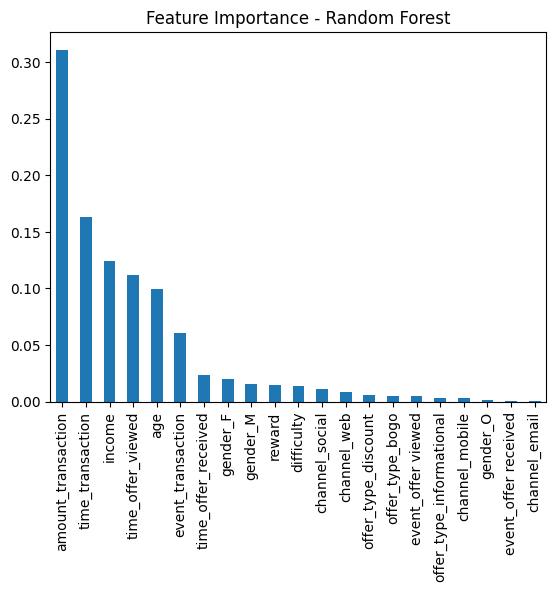

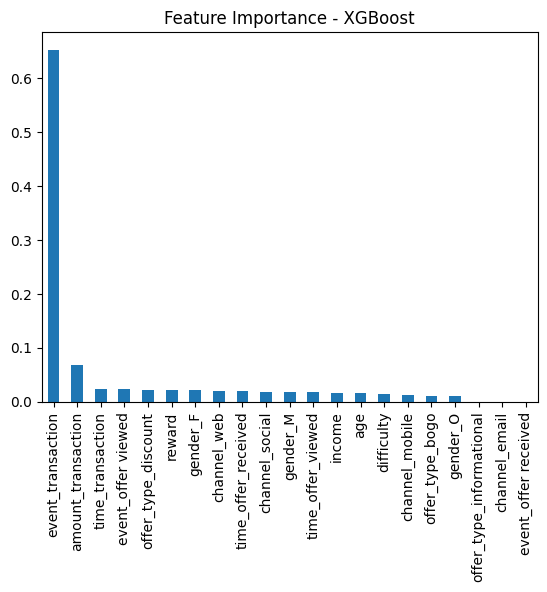

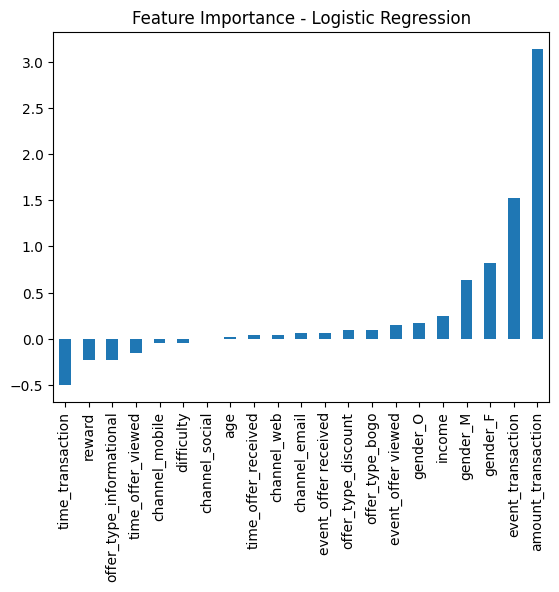

In [58]:
# Feature Importance for Random Forest Classifier, XGBoost  Classifier, and Logistic Regression Classifier
# Random Forest Classifier
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Added to handle NaN
    ('clf', RandomForestClassifier(random_state=42))
])
pipeline.fit(X_train, y_train)
feature_importances = pipeline.named_steps['clf'].feature_importances_
feature_importances = pd.Series(
    feature_importances, index=features).sort_values(ascending=False)
feature_importances.plot(kind='bar', title='Feature Importance - Random Forest')
plt.show()

# XGBoost Classifier
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Added to handle NaN
    ('clf', XGBClassifier(random_state=42))
])
pipeline.fit(X_train, y_train)
feature_importances = pipeline.named_steps['clf'].feature_importances_
feature_importances = pd.Series(
    feature_importances, index=features).sort_values(ascending=False)
feature_importances.plot(kind='bar', title='Feature Importance - XGBoost')
plt.show()

# Logistic Regression Classifier
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Added to handle NaN
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=300, random_state=42))
])
pipeline.fit(X_train, y_train)
coefficients = pipeline.named_steps['clf'].coef_[0]
coefficients = pd.Series(coefficients, index=features).sort_values()
coefficients.plot(kind='bar', title='Feature Importance - Logistic Regression')
plt.show()

### Best model
this section show the best model that was chosen for using on flask app

In [60]:
# Create a dictionary to store the results after GridSearchCV
results_grid_search = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

# Define parameter grids for each model
param_grid_lr = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear']  # Compatible with l1 and l2
}

param_grid_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5]
}

param_grid_xgb = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 5],
    'clf__learning_rate': [0.01, 0.1]
}

# Define pipelines for each model
pipeline_lr = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Added to handle NaN
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=300, random_state=42))
])

pipeline_rf = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Added to handle NaN
    ('clf', RandomForestClassifier(random_state=42))
])

pipeline_xgb = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Added to handle NaN
    ('clf', XGBClassifier(random_state=42, eval_metric='logloss'))
])

# Logistic Regression
grid_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=3, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train, y_train)
y_pred_lr = grid_lr.predict(X_test)
results_grid_search['Accuracy'].append(accuracy_score(y_test, y_pred_lr))
results_grid_search['Precision'].append(precision_score(y_test, y_pred_lr))
results_grid_search['Recall'].append(recall_score(y_test, y_pred_lr))
results_grid_search['F1-Score'].append(f1_score(y_test, y_pred_lr))

# Random Forest
grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)
y_pred_rf = grid_rf.predict(X_test)
results_grid_search['Accuracy'].append(accuracy_score(y_test, y_pred_rf))
results_grid_search['Precision'].append(precision_score(y_test, y_pred_rf))
results_grid_search['Recall'].append(recall_score(y_test, y_pred_rf))
results_grid_search['F1-Score'].append(f1_score(y_test, y_pred_rf))

# XGBoost
grid_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=3, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train, y_train)
y_pred_xgb = grid_xgb.predict(X_test)
results_grid_search['Accuracy'].append(accuracy_score(y_test, y_pred_xgb))
results_grid_search['Precision'].append(precision_score(y_test, y_pred_xgb))
results_grid_search['Recall'].append(recall_score(y_test, y_pred_xgb))
results_grid_search['F1-Score'].append(f1_score(y_test, y_pred_xgb))

# Create a DataFrame to display the results
results_grid_search_df = pd.DataFrame(results_grid_search)
results_grid_search_df

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.820588,0.840283,0.937697,0.886321
1,Random Forest,0.826863,0.847821,0.935857,0.889666
2,XGBoost,0.822157,0.856686,0.914564,0.884679


## Conclusion
### Improvement
While the Random Forest model selected for predicting customer offer completion in the Starbucks use case achieved strong performance—demonstrating an accuracy of 0.826863, precision of 0.847821, recall of 0.935857, and F1-score of 0.889666—there are opportunities for further improvement to enhance its effectiveness and robustness for real-time deployment in the Flask application. Key areas for enhancement include:

 * **Addressing Class Imbalance More Aggressively:** The dataset’s imbalance (3,804 offer completions vs. 1,296 non-completions) led to lower performance on the minority class (False). Implementing advanced techniques, such as stratified oversampling (e.g., SMOTE) or class weighting beyond the default Random Forest settings, could improve precision and recall for non-completed offers, potentially increasing the overall F1-score and reducing false positives or negatives in predictions.
 * **Feature Engineering and Selection:**  Expanding feature engineering efforts could uncover additional predictive signals. For instance, creating interaction terms (e.g., income * age), time-based features (e.g., time differences between events), or aggregating transaction patterns over time could enhance model performance. Additionally, using feature importance analysis from Random Forest to prune less impactful features (e.g., those with low importance scores) could reduce overfitting and improve generalization.
 * **Hyperparameter Optimization:** While GridSearchCV was used to tune Random Forest hyperparameters (n_estimators, max_depth, min_samples_split), exploring a broader parameter space—such as max_features, min_samples_leaf, or bootstrap—could yield further performance gains. Techniques like RandomizedSearchCV or Bayesian optimization could also be employed for more efficient hyperparameter tuning, especially for large datasets.
 * **Model Ensemble or Hybrid Approaches:** Combining Random Forest with other models (e.g., XGBoost or Logistic Regression) in an ensemble or stacking approach could leverage the strengths of each, potentially improving overall predictive power. For example, blending Random Forest’s interpretability with XGBoost’s handling of non-linear relationships could address any remaining gaps in performance.
 * **Real-Time Data Integration:** Enhancing the Flask application to incorporate real-time customer data (e.g., streaming transactions, offer interactions) and periodically retraining the model on updated datasets could maintain its accuracy over time, especially as customer behavior or offer strategies evolve.
These improvements would ensure the model remains robust, scalable, and aligned with Starbucks’ goal of maximizing offer completion rates while minimizing marketing inefficiencies.

### Reflection
This project provided valuable insights into the application of machine learning to predict customer behavior in a real-world marketing context, specifically Starbucks’ promotional offer strategy. Reflecting on the process, several key lessons emerged:

 * **Data Challenges and Preprocessing:** The imbalanced nature of the dataset and the presence of missing or placeholder values (e.g., age = 118, gender = N/A) highlighted the importance of thorough data cleaning and preprocessing. Techniques like mean imputation, categorical encoding, and handling duplicates (duplicate_counts) were critical to creating a modeling-ready dataset (df_m). This experience underscored the need for robust data quality checks and domain knowledge to address business-specific data issues effectively.
 * **Model Selection and Evaluation:** The comparison of Logistic Regression, Random Forest, and XGBoost revealed the importance of selecting evaluation metrics beyond accuracy, particularly for imbalanced data. The choice of Random Forest, driven by its balanced F1-score (0.889666) and interpretability, demonstrated the value of considering precision, recall, and F1-score in tandem with business objectives (e.g., maximizing offer completions while minimizing false positives). The identical initial performance across models (before refinement) also prompted a deeper investigation into data and preprocessing consistency, reinforcing the need for rigorous validation.
 * **Feature Engineering Impact:** The feature engineering process—encoding events, channels, offer types, and gender, as well as aggregating time and transaction data—significantly influenced model performance. Visualizations (fig, fig1, etc.) provided actionable insights into customer demographics and behavior, guiding feature selection and refinement. This experience emphasized the iterative nature of feature engineering and its critical role in unlocking predictive power.
 * **Deployment Considerations:** Preparing Random Forest for deployment in a Flask application highlighted the importance of model scalability, interpretability, and real-time prediction capabilities. The project’s focus on saving the model with joblib and ensuring compatibility with Flask for real-time predictions underscored the need for a seamless bridge between data science and engineering, balancing performance with practical implementation challenges.
 * **Future Directions:** The project’s success in predicting offer completion opens avenues for future work, such as integrating real-time data, exploring advanced ensemble methods, or expanding the model to predict other customer behaviors (e.g., churn, purchase frequency). Reflecting on the process, I recognize the potential to further refine the model by addressing class imbalance more comprehensively and leveraging domain expertise to identify additional predictive features.
Overall, this project not only delivered a practical solution for Starbucks but also deepened my understanding of data-driven decision-making, model evaluation in imbalanced contexts, and the interplay between data science and business applications. It provides a foundation for continuous improvement and application in similar marketing analytics challenges.

The results above provide a detailed overview of the data and the machine learning models used to predict whether a customer will complete a promotional offer. Here's a breakdown of the key components:

### DataFrames
1. **df_m**: This DataFrame contains the cleaned and transformed data, including features such as age, income, event flags, time-related columns, transaction amounts, rewards, offer IDs, and encoded categorical variables like gender and offer type.

2. **df_profile**: This DataFrame contains customer profile information, including gender, age, customer ID, membership start date, and income.

3. **df_trans_profile**: This DataFrame is a merged version of the transcript and profile data, containing information about customer transactions and offers, along with demographic details.

4. **final_df**: This DataFrame is a further processed version of `df_trans_profile`, including additional features and cleaned data for modeling.

### Variables
1. **duplicate_counts**: The number of duplicate entries in the `df_trans_profile` DataFrame based on the 'person' column.

2. **event**: A string representing the event type 'offer completed'.

3. **event_dummies**: A DataFrame containing dummy variables for different event types.

4. **feature_importances**: A Series containing the importance of each feature in the Random Forest model.

5. **features**: An Index object listing the feature names used in the models.

6. **fig, fig1, fig2, fig3, fig4, fig5, fig6**: Plotly figures visualizing various aspects of the data, such as age distribution, gender distribution, income distribution, and offer completion rates by gender, age group, and income group.

### Models and Pipelines
1. **grid, grid_lr, grid_rf, grid_xgb**: GridSearchCV objects for Logistic Regression, Random Forest, and XGBoost models, respectively, used for hyperparameter tuning.

2. **logistic_regression**: A Logistic Regression model object.

3. **model**: The best model selected, which is an XGBoost model in this case.

4. **pipeline, pipeline_lr, pipeline_rf, pipeline_xgb**: Pipelines for Logistic Regression, Random Forest, and XGBoost models, including preprocessing steps like imputation and scaling.

### Parameters and Results
1. **param_grid, param_grid_lr, param_grid_rf, param_grid_xgb**: Dictionaries containing the hyperparameter grids for GridSearchCV for each model.

2. **results, results_df, results_grid_search, results_grid_search_df**: Dictionaries and DataFrames containing the evaluation metrics (Accuracy, Precision, Recall, F1-Score) for each model after GridSearchCV.

### Target and Predictions
1. **y, y_pred, y_pred_lr, y_pred_rf, y_pred_xgb**: Series and arrays containing the true labels and predicted labels for the test set for each model.

2. **y_test, y_train**: Series containing the true labels for the test and training sets.

### Summary
The notebook follows a structured approach to data analysis and modeling:
1. **Data Cleaning and Transformation**: Cleaning and transforming the data to create features suitable for modeling.
2. **Feature Engineering**: Creating new features to improve model performance.
3. **Data Visualization**: Visualizing the data to gain insights into distributions and relationships.
4. **Model Building**: Building and tuning multiple machine learning models using GridSearchCV.
5. **Model Evaluation**: Evaluating the models using various metrics and selecting the best model (Random Forest) based on performance.

The best model (Random Forest) will be used in a Flask application for real-time predictions.